In [2]:
%config Completer.use_jedi = False

from utils import *

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import importlib
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
from scipy import signal

In [3]:
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 80
plt.rcParams["figure.figsize"] = [12,8]

In [4]:
# theory Tc value
TTc = 2/np.log(1+np.sqrt(2))

# Load data from simulation 

In [5]:
with open("dumps/heat-capac-freebc-1e7-4096.pkl", "rb") as f:
    results = pickle.load(f)

In [9]:
with open("dumps/heat-capac-2-96-1e7-4096.pkl", "rb") as f:
    results = pickle.load(f)

In [7]:
df = pd.DataFrame(results, columns=["N", "temp", "len(Es)", "pos1","pos2", "mean_E", "std_E", "E^3", "E^4"])
df["C"] = df.std_E**2/df.temp**2

gb = df.groupby("N")

# Find peaks

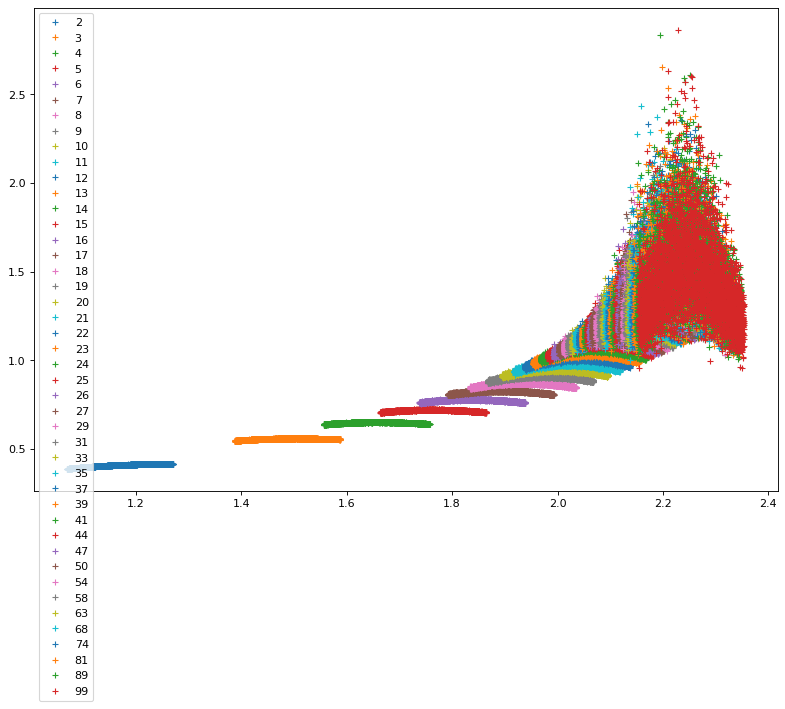

In [9]:
Ns = []
Tcs3 = []
Tcs3_err = []
Ccs3 = []
Ccs3_err = []

w = 91

for N in sorted(gb.groups.keys())[:]:
    Ns.append(N)
    
    df4 = gb.get_group(N)
    temp, C = df4.temp.values, (df4.C/N**2).values
    plt.plot(temp, C,"+", label=f"{N}")
   
    def f(x, p, a, b):
        return a - b*abs(x-(p))**(2)
    try:
        popt, popt_cov = curve_fit(f, temp, C, maxfev=5000, 
                                  p0=[TTc-0*0.3, C.mean(), 100])
        Tcs3.append(popt[0])
        Tcs3_err.append(popt_cov[0,0]**0.5)
        
        Ccs3.append(popt[1])
        Ccs3_err.append(popt_cov[1,1]**0.5)
        
    except Exception as e:
        Tcs3.append(np.nan)
        Tcs3_err.append(np.nan)
        print("1)", N, e)
   
    temp, C = df4.temp.iloc[w//2:-(w//2)], moving_average(df4.C.values/N**2, w=w)
    

plt.legend()
Ns, Tcs3, Tcs3_err = arrayify(Ns, Tcs3, Tcs3_err)

# check problematic N's

For some values of N function may not fit for bad initial parameters

(0.0, 3.0)

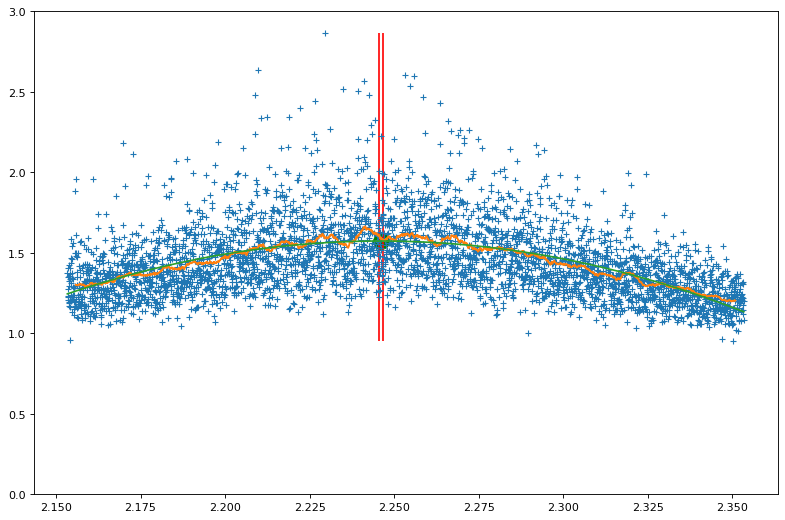

In [10]:
w=101
N=99
df4 = gb.get_group(N)
plt.plot(df4.temp, df4.C/N**2,"+", label=f"{N}")

temp, C = df4.temp.iloc[w//2:-(w//2)], moving_average(df4.C.values/N**2, w=w)
plt.plot(temp, C)
temp, C = df4.temp, df4.C/N**2

def f(x, p, a, b):
        return a - b*abs(x-(p))**(2)
# popt, popt_cov = curve_fit(f, df4.temp, df4.C/N**2, maxfev=5000, 
#                                   p0=[TTc+0.3, 1.5, 1])

popt, popt_cov = curve_fit(f, temp, C, maxfev=5000, 
                                  p0=[TTc+0.3, C.mean(), 100])
plt.plot(df4.temp, f(df4.temp, *popt))
plt.scatter(popt[0], f(popt[0], *popt), c="g", s=200)
plt.vlines(popt[0]-popt_cov[0,0]**0.5, ymin=min(df4.C/N**2), ymax=max(df4.C/N**2), color="r")
plt.vlines(popt[0]+popt_cov[0,0]**0.5, ymin=min(df4.C/N**2), ymax=max(df4.C/N**2), color="r")

plt.ylim(0,3)

# Plot Heat capacity

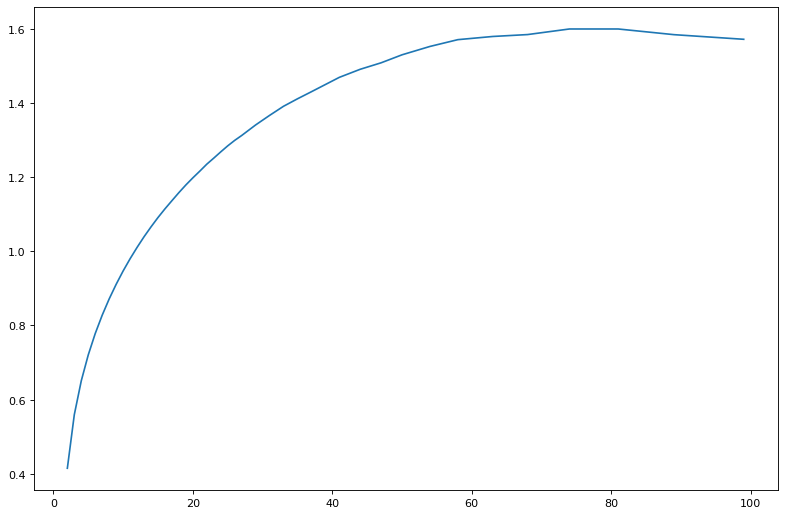

In [35]:
plt.plot(Ns, Ccs3)

# fit model

T=2.2836 a=-2.254 mu=1.117    Tc = 2.26919
T=0.0005 a=0.012056 mu=0.003762


(array([1., 3., 4., 3., 1., 8., 4., 8., 3., 2.]),
 array([-7.83179997e-04, -6.37764399e-04, -4.92348800e-04, -3.46933202e-04,
        -2.01517604e-04, -5.61020056e-05,  8.93135926e-05,  2.34729191e-04,
         3.80144789e-04,  5.25560387e-04,  6.70975986e-04]),
 <BarContainer object of 10 artists>)

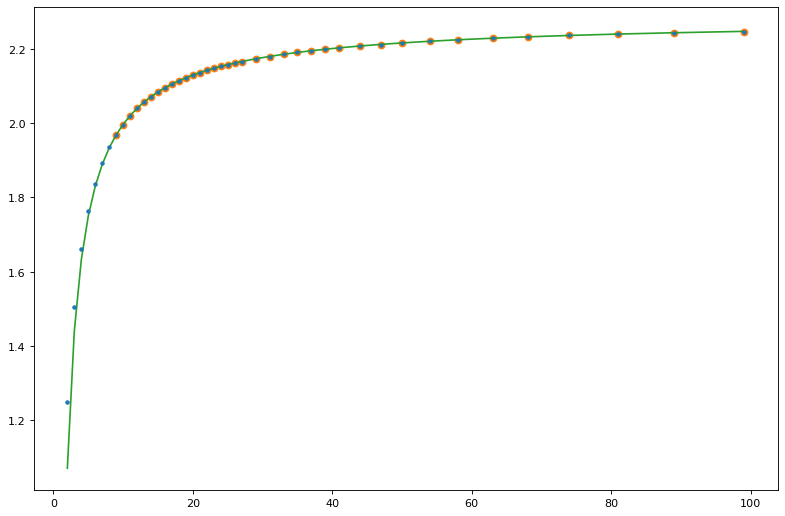

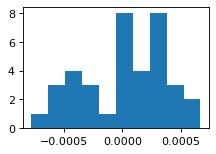

In [21]:
l,r= 7, 1000
def f(x, Tc, a, nu):
    return Tc + a / (x ** (1/nu))
popt3, popt3_cov = curve_fit(f, Ns[l:r], Tcs3[l:r], sigma=np.array(Tcs3_err)[l:r])

Tc, a, mu = popt3
print(f"T={Tc:0.4f} a={a:0.3f} mu={mu:0.3f}    Tc = {TTc:0.5f}")
Tc_err, a_err, mu_err = np.sqrt(popt3_cov.diagonal())
print(f"T={Tc_err:0.4f} a={a_err:0.6f} mu={mu_err:0.6f}")


plt.errorbar(Ns, Tcs3, yerr=np.array(Tcs3_err)*10, fmt=".")
plt.plot(Ns[l:r], Tcs3[l:r], "o")
plt.plot(Ns, f(np.array(Ns), *popt3))
plt.figure(figsize=(3,2))
plt.hist((f(np.array(Ns), *popt3)-Tcs3)[l:r])

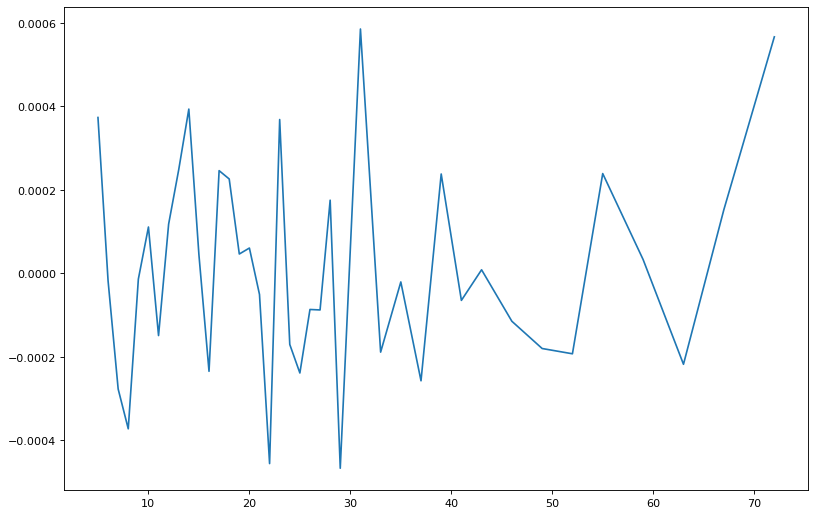

In [66]:

plt.plot(Ns[l:r], (f(np.array(Ns), *popt3)-Tcs3)[l:r])


# Guess $\nu=1$

In [44]:
l,r=4,-4
def f(x, Tc, a):
    return Tc + a * x
popt3, popt3_cov = curve_fit(f, 1/Ns[l:r], Tcs3[l:r], sigma=np.array(Tcs3_err)[l:r])

Tc, a = popt3
print(f" T={Tc:0.4f}   a={a:0.3f}   Tc = {TTc:0.5f}")
Tc_err, a_err = np.sqrt(popt3_cov.diagonal())*3
print(f"dT={Tc_err:0.4f}  da={a_err:0.6f}     {Tc-Tc_err:0.4f}..{Tc+Tc_err:0.4f}")


 T=2.2708   a=0.734   Tc = 2.26919
dT=0.0010  da=0.014489     2.2698..2.2718


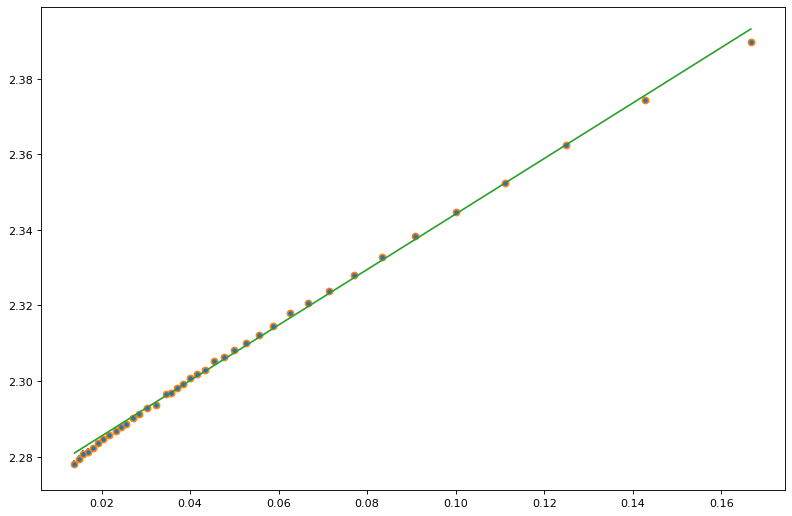

In [45]:
# plt.errorbar(1/Ns, Tcs3, yerr=Tcs3_err*10, fmt=".")
plt.errorbar(1/Ns[l:r], Tcs3[l:r], yerr=Tcs3_err[l:r]*3, fmt=".")
plt.plot(1/Ns[l:r], Tcs3[l:r], "o")
plt.plot(1/Ns[l:r], f(np.array(1/Ns[l:r]), *popt3))
# plt.gca().set_xscale("log")